In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import random
from scipy.io import loadmat

from tsfresh import extract_relevant_features

import os

In [2]:
# files = [f'waveforms/{f}' for f in os.listdir('waveforms') if 'HG8707' in f or 'HJ3311' in f]
# files = [f'waveforms/{f}' for f in os.listdir('waveforms') if 'clean' in f and 'diast' not in f and 'trended' not in f]

class epahClassifier():
    def __init__(self, waveforms=None, labels=None):
        self.waveforms = waveforms
        self.labels = labels
    
    def load_waveforms_from_files(self, files):
        # Load time series into DataFrame
        df_list = []
        for file in files:
            # Load ECG data from the downloaded MATLAB file
            mat = loadmat(file)
            file_id = file.split('.')[0]
            file_id = file_id.split('/')[-1]
            
            # For now, there are two types of files
            # - Files ending in '_000' only contain ONE waveform
            # - Files containing 'clean' may contain MULTIPLE waveforms
            if 'wave' in mat:
                # Note: Each file only contains ONE waveform!
                wave = mat['wave'][0][0][13][3]

                for i, x in enumerate(wave):
                    df_dict = {
                        'id':      file_id,
                        'time':    i,
                        'value':   wave[i],
                    }

                    df_list.append(df_dict)
                    
            elif 'savecleanforms' in mat:
                # Note: Each file may contain multiple waveforms!
                waves = mat['savecleanforms']['wave']
                
                # Create entries for each waveform in the mat file
                for wave_num, wave in enumerate(waves.item()[0]):
                    wave = wave[0]
                    
                    for i, x in enumerate(wave):
                        df_dict = {
                            'id':      f'{file_id}_{wave_num}',
                            'time':    i,
                            'value':   wave[i],
                        }
                        
                        df_list.append(df_dict)

        self.waveforms = pd.DataFrame(df_list)
    
    def load_labels_from_files(self, files):
        # Load labels into Data Series
        labels_dict = {}
        ind = []
        for file in files:
            file_id = file.split('_')[0]
            
            if mat.has_key('wave'):
                # Note: Each file only contains ONE waveform!
                labels_dict[file_id] = int(data[0] % 2)
                ind.append(file_id)
                
            elif mat.has_key('savecleanforms'):
                # Note: Each file may contain multiple waveforms!
                labels_dict[file_id] = int(data[0] % 2)
                ind.append(file_id)

        self.labels = pd.Series(labels_dict, index=ind)

In [112]:
epah = epahClassifier()

files_in_folder = [f'waveforms/{f}' for f in os.listdir('waveforms') if 'clean' in f and 'diast' not in f and 'trended' not in f and 'EL1030' not in f]

df_labels = pd.read_csv('labels.csv')
df_labels['Filename'] = df_labels['Filename'].str.strip()
df_labels = df_labels.set_index(['Filename'])
df_labels['File_Exists'] = [any(filename.split('_')[0] in f for f in files_in_folder) for filename in df_labels.index]
df_labels['RHC_and_Exists'] = ~df_labels['RHC_or_CPET'] & df_labels['File_Exists']
df_labels['Label'] = df_labels['Source'].map({'control': 0, 'pah': 1, 'epah': 2})

files = [f'waveforms/{f.strip()}cleanforms.mat' for f in df_labels[df_labels['RHC_and_Exists']].index]

epah.load_waveforms_from_files(files)

print(f'Data Size: {len(files)}')

print(f'# Waveforms: {len(epah.waveforms.id.unique())}')

Data Size: 25
# Waveforms: 156


In [113]:
id_list = list(epah.waveforms['id'])

labels_dict = {}
for file_id in id_list:
    labels_dict[file_id] = df_labels.loc[file_id.split('clean')[0]]['Label']

epah.labels = pd.Series(labels_dict, index=list(labels_dict.keys()))
display(epah.labels)

print()
print(epah.labels.value_counts())

HJ6108_WAV_004cleanforms_0    0
HJ6108_WAV_004cleanforms_1    0
HJ6108_WAV_004cleanforms_2    0
HJ6108_WAV_004cleanforms_3    0
HJ6108_WAV_004cleanforms_4    0
                             ..
HH3542_WAV_004cleanforms_2    2
HH3542_WAV_004cleanforms_3    2
HH3542_WAV_004cleanforms_4    2
HH3542_WAV_004cleanforms_5    2
HH3542_WAV_004cleanforms_6    2
Length: 156, dtype: int64


2    65
1    61
0    30
dtype: int64


In [ ]:
features_filtered_direct = extract_relevant_features(epah.waveforms, epah.labels,
                                                     column_id='id', column_sort='time',
                                                     column_value='value')

In [ ]:
features_filtered_direct

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from tsfresh.transformers import RelevantFeatureAugmenter
from tsfresh.utilities.dataframe_functions import impute

In [129]:
# Classes:
# 0: Control
# 1: PAH
# 2: EPAH

# Remove Class
# -1 -->  keep all 3 classes
# 0  -->  PAH vs EPAH
# 1  -->  Control vs EPAH
# 2  -->  Control vs PAH
class_remove = 1
    
y = epah.labels[epah.labels != class_remove]

X = pd.DataFrame(index=y.index)

# Split data into train and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y)

# Ensure even split between labels
# FOR NOW, pick 2 patients randomly from each class
pt_list = list(set(ind.split('_')[0] for ind in y.index))

pt_labels = []
for pt in pt_list:
    label = y[[pt in ind for ind in y.index]][0]
    weight = sum([pt in ind for ind in y.index])
    
    pt_labels.append({
        'pt':     pt,
        'label':  label,
        'weight': weight,
    })

pt_df = pd.DataFrame(pt_labels)

if class_remove == 0:
    pt_test = pd.concat([pt_df[pt_df['label'] == 1].sample(n=3),
                         pt_df[pt_df['label'] == 2].sample(n=3)])
elif class_remove == 1:
    pt_test = pd.concat([pt_df[pt_df['label'] == 0].sample(n=2),
                         pt_df[pt_df['label'] == 2].sample(n=3)])
elif class_remove == 2:
    pt_test = pd.concat([pt_df[pt_df['label'] == 0].sample(n=2),
                         pt_df[pt_df['label'] == 1].sample(n=3),])
else:
    pt_test = pd.concat([pt_df[pt_df['label'] == 0].sample(n=2),
                         pt_df[pt_df['label'] == 1].sample(n=3),
                         pt_df[pt_df['label'] == 2].sample(n=3)])

display(pt_test)

y_train = y[[all(pt not in ind for pt in pt_test['pt']) for ind in y.index]]
X_train = X[[all(pt not in ind for pt in pt_test['pt']) for ind in X.index]]
y_test = y[[any(pt in ind for pt in pt_test['pt']) for ind in y.index]]
X_test = X[[any(pt in ind for pt in pt_test['pt']) for ind in X.index]]

print(f'Training Split: {len(y_train)}')
print(f'Testing  Split: {len(y_test)}')

,pt,label,weight
15,HG6937,0,4
4,HJ5111,0,6
11,HJ6338,2,5
13,HJ5879,2,4
6,HJ4998,2,7


Training Split: 69
Testing  Split: 26


In [130]:
ppl = Pipeline([
        ('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='time')),
        ('classifier', RandomForestClassifier())
      ])

ppl.set_params(augmenter__timeseries_container=epah.waveforms[epah.waveforms['id'].isin(y.index)])

ppl.fit(X_train, y_train)

y_pred = ppl.predict(X_test)

print(classification_report(y_test, y_pred))

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 23/23 [00:04<00:00,  4.76it/s]
C:\Users\andre\miniconda3\envs\epahClassification\lib\site-packages\tsfresh\utilities\dataframe_functions.py:171: RuntimeWarning: The columns ['value__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn("The columns {} did not have any finite values. Filling with zeros.".format(
Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 10.95it/s]


              precision    recall  f1-score   support

           0       0.40      0.40      0.40        10
           2       0.62      0.62      0.62        16

    accuracy                           0.54        26
   macro avg       0.51      0.51      0.51        26
weighted avg       0.54      0.54      0.54        26



Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 26/26 [00:02<00:00, 10.99it/s]


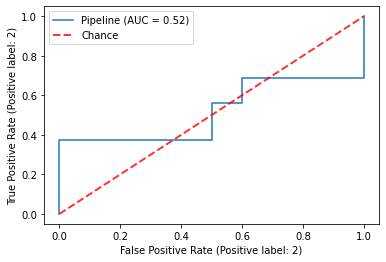

In [131]:
from sklearn.metrics import plot_roc_curve

fig, ax = plt.subplots()
plot_roc_curve(ppl, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.legend()

In [ ]:
ppl.named_steps["augmenter"].feature_selector.relevant_features